In [1]:
# typical python libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pickle

# vorbin package by M. Capellari
from vorbin.voronoi_2d_binning import *

# hoki sedfitting subpackage
import hoki.sedfitting as hsed

plt.style.use('../tuto.mplstyle')

# Vornoi Binning and retrieveing SEDs of the binned data

In this jupyter notebook we will work with a cropped data cube of NGC 4993 (reduced by Joe Lyman) that is centered(-ish) on the galaxy and extends to comfortably contain the galaxy and the transient AT 2017gfo (top left in the image below). 

In this notebook we will mostly use the voronoi binning algorithm of M. Cappellari ([see website](https://www-astro.physics.ox.ac.uk/~cappellari/software/#binning)) and a few utilities I wrote and put in `hoki.sedfitting` such as `plot_voronoi`. 

**Other dependency:** `mpdaf` was used to create the cropped data cube. It is a pretty commonly used IFU data utility package. For further information see [their documentation](https://mpdaf.readthedocs.io/en/latest/).

## Loading the cropped data cube

First let's take a look at the data cube:

In [2]:
with open('data/cropped_NGC4993.pkl', 'rb') as pickle_file:
    cube = pickle.load(pickle_file)

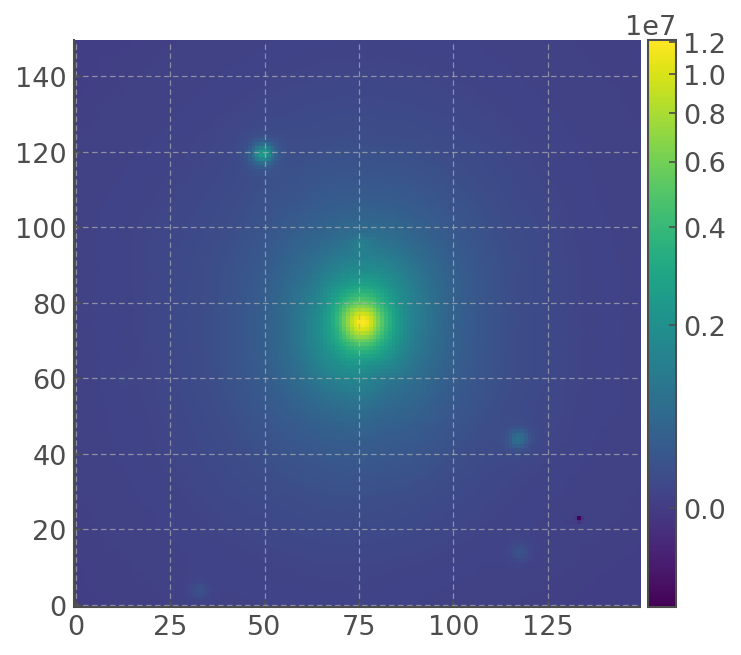

In [3]:
plt.figure()

ima = cube.sum(axis=0) # to make the image we sum over the wavelength axis to get the total flux
ima.plot(scale='arcsinh', colorbar='v') # this scaling with arcsinh was copied from mpdaf tutorials - it works

okay let's take a look at what's in this `cube` object. First checking the shape is quite informative:

In [4]:
cube.data.shape

(3681, 150, 150)

so axis 0 is the wavelength, which is why we summed over axis=0 earlier, and then each side of the image is 150 pixels. The original images from MUSE are much larger but I cropped it to make it easier to upload and download (and also to not fill the RAM when working on the data!)

Now let's look at one of the headers, the `data_header`:

In [5]:
cube.data_header

XTENSION= 'IMAGE   '           / Image extension                                
BITPIX  =                  -64 / array data type                                
NAXIS   =                    3 / number of array dimensions                     
NAXIS1  =                  150                                                  
NAXIS2  =                  150                                                  
NAXIS3  =                 3681                                                  
PCOUNT  =                    0 / number of parameters                           
GCOUNT  =                    1 / number of groups                               
WCSAXES =                    3 / Number of coordinate axes                      
CRPIX1  =      53.754912632071 / Pixel coordinate of reference point            
CRPIX2  =      128.27776222996 / Pixel coordinate of reference point            
CUNIT1  = 'deg'                / Units of coordinate increment and value        
CUNIT2  = 'deg'             

`CRVAL3` is the first wavelength bin and `CD3_3` is the $\Delta \lambda$ = 1.25 in this case. We're going to need this in a minute. 

## Voronoi Binning

In this particular situation Voronoi binning is creating tiles over the image in such a way that we homogenise the signal-to-noise-ratio across our bins. At the moment our bins are just pixels, and obviously the pixels on the outside of the image have much lower SNR than the ones in the middle of the galaxy. 

What we're going to do now is use the `vorbin` algorithm to create tiles of adjacent pixels which, when summed together give use a spectrum with SNR close to our target SNR (and you get to pick what that target is). 

### Book keeping - creating our wavelength array

In [6]:
# The first thing we need to do is create the wavelength scale. We've only got a starting
# wavelength, a Delta lambda and a number of bins in the spectrum (3861 - see above)
# The code below creates the wavelength array

# minimum and maximum wavelength from the header
wl_min = cube.data_header['CRVAL3']
wl_max = cube.data_header['CRVAL3']+cube.data_header['CD3_3']*cube. data.shape[0]

# creating the wavelength array
WL = np.arange(cube.data_header['CRVAL3'], wl_max, cube.data_header['CD3_3'])

In [7]:
# just to check our array has indeed got the right size
WL.shape[0]

3681

### Book keeping - creating the pixel coordinate, signal and noise arrays

In [8]:
# First we need to make lists of pixel Coordinates
# note this will be stupid big with large data cubes 
# in that case find a smartter way to make these arrays

# ... X is a 1D list of length 150**2 
X = []
for x in np.arange(0, cube.shape[2]):
    X+=[x]*cube.shape[2]
    
x =  np.array(X)

# ... Y is a 1D list of length 150**2 
Y=[]
for y in np.arange(0,cube.shape[1]):
    Y+=list(np.arange(0,cube.shape[1]))   

y =  np.array(Y)

In [9]:
# Now we store the signal (spectrum) in its own array
signal = ima.data.data.reshape(-1,1) # this reshape(-1,1) turns the 2D array in a 1D array. 

In [10]:
# And now we store the errors in their own array
noise = np.sqrt(ima.var.data.reshape(-1,1))

## Binning! 

In [11]:
# pick a target signal to noise ratio - I picked 40 
TARGET_SNR = 40

### Calculating SNR in a line-free region

To compare SNR from spectrum to spectrum we need to chose an area of the spectrum that is devoid of strong lines across our whole data set and then calculate the SNR in that range. 

In [12]:
# range of wavelength between which we calculate the SNR
wlmin_snr = 5590
wlmax_snr= 5680

# Finding the indices corresponding to the min and max wavelengths of our range to calc SNR
i_min = (np.abs(WL-wlmin_snr)).argmin()
i_max = (np.abs(WL-wlmax_snr)).argmin()+1

# Calculating the SNR in that range
signal = np.mean(cube.data[i_min:i_max,:,:], axis=0).reshape(-1,1) # again making it 1D with the reshape trick
noise = np.sqrt(np.mean(cube.var[i_min:i_max,:,:], axis=0)).reshape(-1,1) 

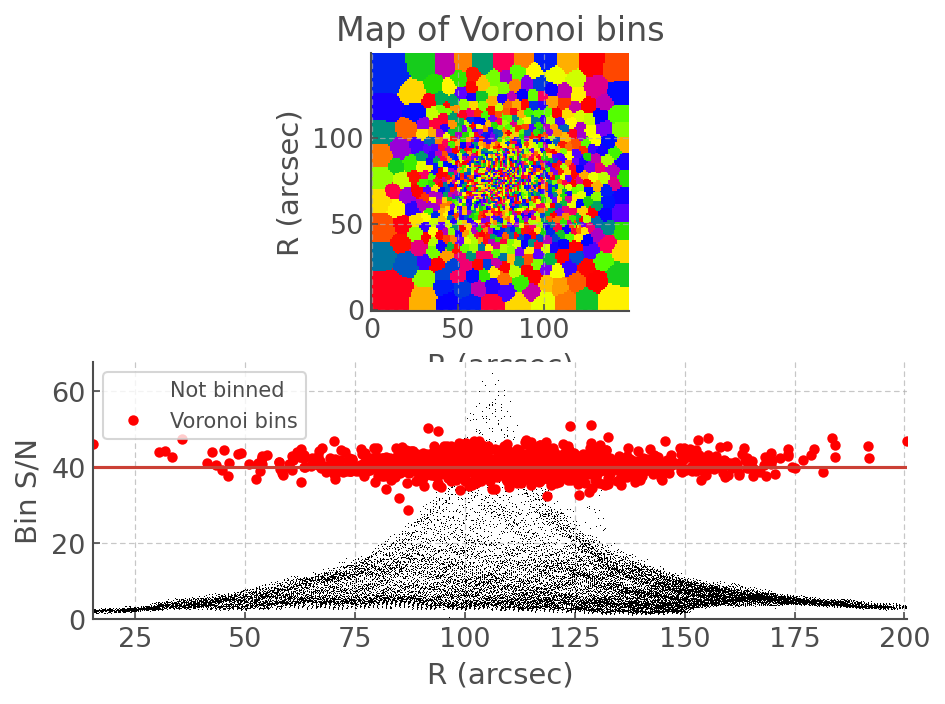

In [13]:
# Summoning vorbin!!!
binNum, xNode, yNode, xBar, yBar, sn, nPixels, scale = voronoi_2d_binning(x, y, signal, noise, 
                                                                          TARGET_SNR, plot=1, quiet=1,
                                                                          pixelsize=1, 
                                                                          )

## Comments and thoughts on the vorbin process:
First of all notice that there is a scatter in SNR around the target we chose: that is to be expected, there is a finite number of adjacent pixels to chose from! 

Also note that in the center there are a lot of pixels that are not binned because they already exceed the SNR threshold. This is something we will discuss a little more later because the boudnary between binned and not-binned creates a little bit of structure in our SNR map (see below). 

Finally note that there is a little bit of randomness in the process of optimising for the binning so you might get a slightly different result everytime you run it, but not by much and not enough to mess with your science (given that you picked an SNR that is high enough for what you need to do). This is a good place to point out that the target SNR **is NOT a minimum SNR**, so if you have a minimu SNR in mind, check the plot above after you've picked a target SNR and adjust as you need to ensure the majority of your bins end up reaching that minimum SNR you desire. 

### Storing the results

In order to store the vorbin results (temporarily; just for use later in the notebook) I've made a little class. It's v. much not necessary, feel free to amend!

In [14]:
class VorbinResults():
    """
    Object to contain the quantities returned by vorbin_2d - they don't fit neatly into a table
    """
    def __init__(self, X, Y, binNum, xNode, yNode, xBar, yBar, sn, nPixels, scale):
        self.X = X # x coordinates (size - Nbins, here 150**2)
        self.Y = Y # y coordinates (size - Nbins, here 150**2)
        self.binNum = binNum # vornoi bin number
        self.xNode =  xNode # x coordinate of each vorbin center
        self.yNode = yNode # y coordinate of each vorbin center
        self.xBar = xBar # see voronoi_2d_binning Output Parameters
        self.yBar = yBar
        self.sn = sn # SNR
        self.nPixels = nPixels # number of pixels in each bin
        self.scale = scale # see voronoi_2d_binning Output Parameters


In [15]:
# storing the results in our little object
vorbin = VorbinResults(X, Y, binNum, xNode, yNode, xBar, yBar, sn, nPixels, scale)     

# Binning the spectra

Now that we have voronoi bins and we know which pixel belongs in which bin, we can put our spectra together to caculate the integrated spectra of each bin. Let's do this!

In [16]:
# first I create a dataframe that tells us which bin each (x,y) location belongs to
bin_keys=pd.DataFrame(np.array([vorbin.X, vorbin.Y, vorbin.binNum]).T, columns=['X','Y','binNum'])
bin_keys.head()

X  Y  binNum
0  0  0    1475
1  0  1    1475
2  0  2    1475
3  0  3    1475
4  0  4    1475

In [17]:
# we'll need to know the number of wavelength bins
wl_len = cube.shape[0]
wl_len

3681

### Let's bin the SEDs!

In [18]:
# list of spectra. By the end of the loop there should be binNum spectra corresponding to each vorbin
spectra=[] 

# we loop over the number of voronoi bins
for i in range(bin_keys.binNum.max()+1): 
    # Y, X coordinates of all the pixels in the ith voronoi bin (binNum)
    coords_i=bin_keys[bin_keys.binNum==i][['X','Y']].values
    # instanciate a np array of the size of the SED filled with zeros
    spectrum = np.zeros(wl_len)
    
    # for each pixel in this voronoi bin...
    for coord in coords_i: 
        # ..add up all the fluxes 
        spectrum+=cube.data.data[:,coord[0],coord[1]]
    
    # ... then we add this spectrum to our list of spectra
    spectra.append(spectrum)
    
# turn the list into an array
spectra=np.array(spectra)


#### QUALITY CONTROL

# want to make sure the spectra don't have negative values or nan values
spectra = np.where(spectra>0.0, spectra, 1e-15) # NO NEGATIVES
spectra = np.where(spectra!=np.nan, spectra, 1e-15) # NO NAN


<ipython-input-18-ed04e47ac8b7>:26: RuntimeWarning: invalid value encountered in greater
  spectra = np.where(spectra>0.0, spectra, 1e-15) # NO NEGATIVES


In [19]:
# finally I like to stack the wavelength array and the spectra
# so i=0 is the wavelength 
# and every row after that is a spectrum 
spectra=np.vstack([WL,spectra])

### repeat for the standard deviations!

In [27]:
stds=[] # list of standard deviations

for i in range(bin_keys.binNum.max()+1):
    
    # Y, X coordinates of all the pixels in the ith voronoi bin (binNum)
    coords_i=bin_keys[bin_keys.binNum==i][['X','Y']].values
    # instanciate a np array of the size of the spectrum filled with zeros
    std_i = np.zeros(wl_len)
    
    for coord in coords_i: # for each pixel in this bin...
        std_i+=cube.var.data[:,coord[0],coord[1]] #add the variances - same as adding the std in quadrature
     
    # then we square root the whole thing...
    std_i = np.sqrt(std_i)   
    # ... before adding it to our list ...
    stds.append(std_i)

    
# ... and finally we stack our noise spectra together with the wavelengths as the frist row
spectra_errs= np.vstack([WL,stds])

#### QUALITY CONTROL   
spectra_errs = np.where(spectra_errs!=np.nan, noises, 1e15)
spectra_errs = np.where(spectra_errs>0.0, noises, 1e15)

In [37]:
np.save('data/vorbinned_spectra.npy', spectra)
np.save('data/vorbinned_specerr.npy', spectra_errs)

## SNR map!

To see how good a job we did in homogeneising the SNR we can plot it with a colour map. Here what we're going to do is take the minimum of the SED/NOISE array for each bin:

In [30]:
min_snrs = [] # list of the minimum SNRs 

for spec, std in zip(spectra, spectra_errs): 
    snr = spec/std # calculate SNR for each bin
    min_snrs.append(min(snr)) # append the minimum 
    
min_snrs = np.array(min_snrs) # make it an array

In [31]:
# At this point we have to flip x and y in the array so things plot the right way around
# not sure if I messed up earlier or if its a "feature"

pd.DataFrame(np.array([y,x, sn[binNum], binNum]).T, 
             columns=['x', 'y', 'sn', 'binNum']).to_csv('data/voronoi_bins_NEW.txt', index=False)

Text(0.5, 1.0, 'SNR')

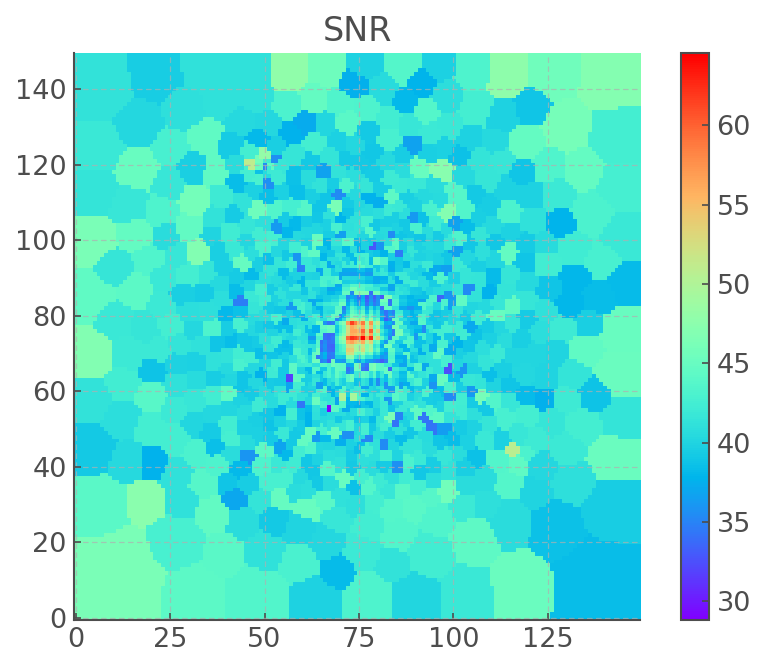

In [32]:
fig, ax = plt.subplots(1,1)

# note that here  we have to flip the y and x axes to have the plot come out right
# that is why we took that weird step above before saving the results. 
# in future analysis when loading that data frame x and y will be the right way around
sn_color = hsed.plot_voronoi(y,x, sn[binNum], pixelsize=1, ax=ax, cmap='rainbow')
fig.colorbar(sn_color)
ax.set_title('SNR')

In [33]:
type(sn_color)

matplotlib.image.AxesImage

Our SNR map looks decent! obviously the center glows well above our threshold value because galaxies are bright. We notice a sort of ring of blue (lower SNR) around the bright region ad we transition to larger bins: that is because at this point the algorithm is between a rock and a hard place: the pixel itself is on the cusp of meeting the SNR threshold but combining two of them makes it crazy high compared to what we ask! That transitional phase between unbinned and binned pixels is expected and you might see it in your own images when you perform this exercise!


### Next tutos:
- SED fitting integrated spectrum with Kvn
- SED fitting all the bins with LordCommander